In [1]:
%matplotlib inline
import bisect
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Clique detection algorithm

In this notebook we'll implement the clique detection algorithm on a set consisting of 3 complete small graphs. This algorithm is a variant of the subgraph mining algorithm which consist of finding graphs that are isomorphic to a subgraph of another graph.

The problem of finding an isomorphism between two graphs can be reframed as finding two graphs whose canonical label is equal. The canonical label of a graph is a string representation of a graph which is obtained by concatenating the rows of it's adjacency matrix. There are many different labels for a given graph, so the one with the minimum lexicographical order is taken and it's representative of the graph. If another graph has the same canonical label, then they are isomorphic. Thus, the problem of ismorphism is reduced to a string comparison problem. 

First we'll create a set of 3 graphs. Each of these graphs will contain a 3-clique that is common to all. The algorithm should be able to find this 3-clique.

The graphs will be named G, J and H. The first two will contain 4 nodes each and the latter will contain 6 nodes. We'll create them in network-x to visualize them.

In [2]:
# This is the clique that is common to all graphs in the set
clique = [
        ("A", "D"),
        ("A", "R"),
        ("D", "R"),
    ]

In [3]:
# Create G

G = nx.Graph()
G.name = "G"
edges = [
    ("A", "D"),
    ("A", "N"),
    ("A", "R"),
    ("D", "N"),
    ("D", "R"),
    ("N", "R"),
]

labels = [4, 3, 5, 8, 2, 4]

for ii in range(len(edges)):
    if edges[ii] in clique:
        G.add_edge(edges[ii][0], edges[ii][1], dis=labels[ii], color="red")
    else:
        G.add_edge(edges[ii][0], edges[ii][1], dis=labels[ii], color="black")

assert G.number_of_edges() == (G.number_of_nodes() * (G.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [4]:
# Create J
# J is very similar to G. The only difference is the label N is replaced by P

J = nx.Graph()
J.name = "J"
edges = [
    ("A", "D"),
    ("A", "P"),
    ("A", "R"),
    ("D", "P"),
    ("D", "R"),
    ("P", "R"),
]
labels = [4, 3, 5, 8, 2, 4]

for ii in range(len(edges)):
    if edges[ii] in clique:
        J.add_edge(edges[ii][0], edges[ii][1], dis=labels[ii], color="red")
    else:
        J.add_edge(edges[ii][0], edges[ii][1], dis=labels[ii], color="black")

assert J.number_of_edges() == (J.number_of_nodes() * (J.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [5]:
# Create H
# H is a supergraph of G

H = copy.deepcopy(G)
H.name = "H"
edges = [
    ("A", "H"),
    ("A", "P"),
    ("D", "H"),
    ("D", "P"),
    ("N", "H"),
    ("N", "P"),
    ("R", "H"),
    ("R", "P"),
    ("H", "P")
]
labels = [4, 3, 5, 5, 6, 2, 8, 7, 4]

for ii in range(len(edges)):
    H.add_edge(edges[ii][0], edges[ii][1], dis=labels[ii], color="black")

assert H.number_of_edges() == (H.number_of_nodes() * (H.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [6]:
def draw_graphs(graphs):
    """ Function to draw the graphs and color the 3-clique that all share.
    
        Parameters
        ----------
        graphs : list of networkx.Graph
            List of graphs
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))
    
    for ii, graph in enumerate(graphs):
        pos = nx.circular_layout(graph)
        colors = [graph[u][v]["color"] for u,v in graph.edges]
        nx.draw(graph, pos, ax=axes[ii] ,edge_color=colors, with_labels=True)
        axes[ii].set_axis_off()
        
    plt.show()

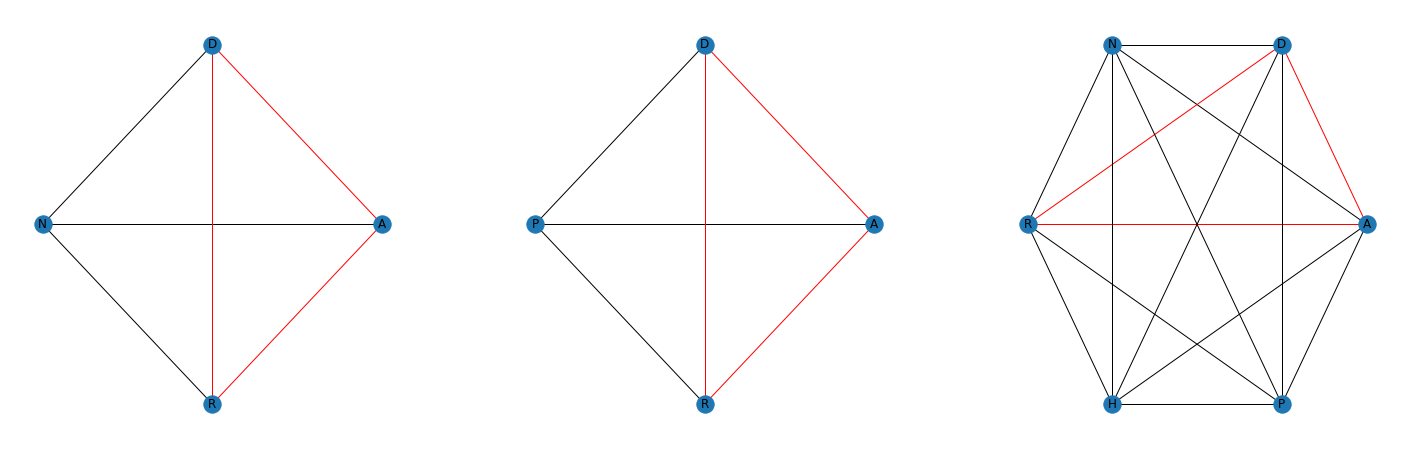

In [7]:
draw_graphs([G, J, H])

## Adjacency matrix and canonical code

We will represent each graph as an adjacency matrix. With this, we can get the canonical code of the graph.

For this problem we will use an adjacency matrix whose diagonal entries are the node labels, and the other entries correspond to the edges labels.

A graph can have multiple adjacency matrices, depending on the order on which the nodes and edges are added to the matrix.

In [8]:
def adjacency_matrix(graph):
    """ Construct the adjacency matrix of the graph.
    
        Parameters
        ----------
        graph : networkx.Graph
            The graph.
            
        Returns
        -------
        adjacency_matrix : np.ndarray of shape(n_nodes, n_nodes)
            The adjacency matrix.
    """
    n_nodes = graph.number_of_nodes()
    adj_matrix = np.empty((n_nodes, n_nodes), dtype=object)
    
    for ii, node in enumerate(graph.nodes):
        for jj, neighbor in enumerate(graph[node]):
            if ii == jj:
                adj_matrix[ii, jj] = node
            else:
                adj_matrix[ii, jj] = str(graph[node][neighbor]["dis"])
                adj_matrix[jj, ii] = str(graph[node][neighbor]["dis"])
    
    adj_matrix[ii, jj + 1] = node 
                
    return adj_matrix
    

In [9]:
matrices = []
for graph in [G, H, J]:
    matrix = adjacency_matrix(graph)
    matrices.append(matrix)
    print(f"Graph {graph.name}:")
    print(matrix)

Graph G:
[['A' '4' '3' '5']
 ['4' 'D' '8' '2']
 ['3' '8' 'N' '4']
 ['5' '2' '4' 'R']]
Graph H:
[['A' '4' '3' '5' '4' '3']
 ['4' 'D' '8' '2' '5' '5']
 ['3' '8' 'N' '4' '6' '2']
 ['5' '2' '4' 'R' '8' '7']
 ['4' '5' '6' '8' 'H' '4']
 ['3' '5' '2' '7' '4' 'P']]
Graph J:
[['A' '4' '3' '5']
 ['4' 'D' '8' '2']
 ['3' '8' 'P' '4']
 ['5' '2' '4' 'R']]


A graph has (number of edges)! canonical codes. In the case of a graph in which all node labels are different the minimum canonical code can be obtained by sorting the nodes. It gets more complicated for graphs with repeated labels as the labels of the edges also need to be considered.

The minimum canonical code for our graphs are:
- For G: AD4N38R524
- For H: AD4P38R524
- For J: AD4H45N386P3542R52847


In [10]:
def canonical_label(adjacency_matrix):
    """Construct the canonical label for a graph from it's adjacency matrix.
    
        Parameters
        ----------
        adjacency_matrix : np.ndarray of shape(n_nodes, n_nodes)
            The adjacency matrix.
        
        Returns
        -------
        can_label : str
            The canonical code
        
        Note
        -----
        The minimum lexicographical labeling will not necesarily be obtained.
    
    """
    n_nodes = adjacency_matrix.shape[0]
    
    # Add the first node label
    can_label = adjacency_matrix[0, 0]
    for ii in range(1, n_nodes):
        # Get the node label
        can_label += adjacency_matrix[ii, ii]
        # Now we add the edges labels 
        for jj in range(ii):
            can_label += adjacency_matrix[jj, ii]
   
    
    n_edges = (n_nodes * (n_nodes - 1)) / 2
    assert len(can_label) == n_edges + n_nodes
    return can_label

In [11]:
canonical_labels = []
graphs = [G, H, J]
for ii in range(len(matrices)):
    label = canonical_label(matrices[ii])
    print(f"{graphs[ii].name} label is {label}")
    canonical_labels.append(label)

G label is AD4N38R524
H label is AD4N38R524H4568P35274
J label is AD4P38R524


The canonical code for G and H corresponds to the minimum canonical code. This happened because when we constructed the adjacency matrix, the nodes were sorted in alphabetical order. However, for H this was not the case and the code obtained is not the minimum adjacency code.

In [12]:
def minimum_canonical_code(graph):
    """ Get the minimum canonical code of a graph. It assumes that all the nodes have unique labels.
    
        Parameters
        ----------
        graph : networkx.graph
            A graph
        
        Returns
        -------
        can_label
            The minimum canonical label of the graph.
    """
    nodes = sorted(graph.nodes)
    visited = [nodes[0]]
    
    can_label = nodes[0]
    for node in nodes[1:]:
        can_label += node
        for v in visited:
            can_label += str(graph[node][v]["dis"])
        visited.append(node)
    
    assert len(can_label) == graph.number_of_nodes() + graph.number_of_edges()
    return can_label

In [13]:
canonical_labels = []
graphs = [G, H, J]
for ii in range(len(graphs)):
    label = minimum_canonical_code(graphs[ii])
    print(f"{graphs[ii].name} label is {label}")
    canonical_labels.append(label)

G label is AD4N38R524
H label is AD4H45N386P3542R52847
J label is AD4P38R524


### Graphs with repeated labels

To be useful the algorithm also need to be able to handle graphs with repeated labels. Now we create a set of graphs with repeated labels and obtain their minimum canonical code.

In [14]:
graph1 = nx.Graph()
graph1.name = "Graph 1"

nodes = [
    (1, "A"),
    (2, "A"),
    (3, "D"),
    (4, "R"),
]

edges = [
    (1, 2, 3), # node1, node2, edgelabel
    (1, 3, 4),
    (1, 4, 5),
    (2, 3, 8),
    (2, 4, 4),
    (3, 4, 2)
]


for node in nodes:
    graph1.add_node(node[0], feat_type=node[1])

for edge in edges:
    graph1.add_edge(edge[0], edge[1], distance=edge[2])
    
assert graph1.number_of_edges() == (graph1.number_of_nodes() * (graph1.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [15]:
graph2 = nx.Graph()
graph2.name = "Graph 2"

nodes = [
    (1, "A"),
    (2, "R"),
    (3, "H"),
    (4, "D"),
    (5, "H")
]

edges = [
    (1, 2, 7), # node1, node2, edgelabel
    (1, 3, 2),
    (1, 4, 6),
    (1, 5, 5),
    (2, 3, 4),
    (2, 4, 3),
    (2, 5, 5),
    (3, 4, 8),
    (3, 5, 5),
    (4, 5, 4)
]


for node in nodes:
    graph2.add_node(node[0], feat_type=node[1])

for edge in edges:
    graph2.add_edge(edge[0], edge[1], distance=edge[2])
    
assert graph2.number_of_edges() == (graph2.number_of_nodes() * (graph2.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [16]:
graph3 = nx.Graph()
graph3.name = "Graph 3"

nodes = [
    (1, "D"),
    (2, "R"),
    (3, "R"),
    (4, "A"),
    (5, "D"),
    (6, "R"),
]

edges = [
    (1, 2, 4), # node1, node2, edgelabel
    (1, 3, 8),
    (1, 4, 2),
    (1, 5, 5),
    (1, 6, 7),
    (2, 3, 3),
    (2, 4, 7),
    (2, 5, 9),
    (2, 6, 8),
    (3, 4, 6),
    (3, 5, 4),
    (3, 6, 3),
    (4, 5, 5),
    (4, 6, 2),
    (5, 6, 3),
]


for node in nodes:
    graph3.add_node(node[0], feat_type=node[1])

for edge in edges:
    graph3.add_edge(edge[0], edge[1], distance=edge[2])
    
assert graph3.number_of_edges() == (graph3.number_of_nodes() * (graph3.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [33]:
k3 = nx.Graph()
nodes = [(1, "A"),(2, "A"),(3, "A")]
edges = [(1, 2, 4),(1, 3, 3),(2, 3, 2)]
for node in nodes:
    k3.add_node(node[0], feat_type=node[1])
for edge in edges:
    k3.add_edge(edge[0], edge[1], distance=edge[2])     
assert k3.number_of_edges() == (k3.number_of_nodes() * (k3.number_of_nodes() - 1)) / 2 # Condition for complete graphs

In [42]:
sorted(k3.edges.data("distance"), key=lambda item: item[2])

[(2, 3, 2), (1, 3, 3), (1, 2, 4)]

In [35]:
edge = min(k3.edges.data("distance"), key=lambda item: item[2])
edge

(2, 3, 2)

In [41]:
print(k3[2])
print(k3[3])

{1: {'distance': 4}, 3: {'distance': 2}}
{1: {'distance': 3}, 2: {'distance': 2}}


In [45]:
"" < "1"

True